
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°1

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
ENV='local' 
# ENV='colab'

In [3]:
if 'colab' in ENV:
    !sudo apt-get install sox
    !pip install opensmile

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import sys
sys.path.append('../src')

import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
                                    LeaveOneGroupOut, StratifiedKFold, \
                                    cross_val_score, KFold

from sklearn.metrics import accuracy_score

from data   import Dataset
from metric import plot_confusion_matrix, missing_values_summary, \
                   set_summary, show_score, show_summary
from sound  import play, play_audio, get_functional_feats

## Funciones

Funciones usadas para agrupar 2 actores x fold:

In [6]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [7]:
def exclude_columns(df, columns): return df.drop(columns, axis=1)

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [8]:
dataset = pd.read_csv('dataset.csv')

In [9]:
dataset.head()

,Unnamed: 0,actor,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,file,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,audio_type
0,0,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572,speech
1,1,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856,speech
2,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801,speech
3,3,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288,speech
4,4,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256,speech


Audio de un speech:

In [10]:
play(dataset[dataset['audio_type'] == 'speech'].iloc[0, :])

Audio Cantado:

In [11]:
play(dataset[dataset['audio_type'] == 'song'].iloc[0, :])

Quitamos columnas que no vamos usar como:

* file
* modality:
    * 01 = full-AV
    * 02 = video-only
    * 03 = audio-only
* vocal_channel: esta repetida ya tenemos audio_type.
    * 01 = speech
    * 02 = song
* statement
    * 01 = "Kids are talking by the door"
    * 02 = "Dogs are sitting by the door".
* repetition: 
    * 01 = 1st repetition
    * 02 = 2nd repetition
* start: El momento de inicio siempre es cero.
* end: Es la duracion del audio.

In [12]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'vocal_channel',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

In [13]:
examples = dataset[example_columns]

Luego codificamos audio_type como dummy:

In [14]:
examples['audio_type'].value_counts()

speech    1440
song      1012
Name: audio_type, dtype: int64

In [15]:
examples['audio_type'] = pd.get_dummies(examples['audio_type'])

In [16]:
examples['audio_type'].value_counts()

0    1440
1    1012
Name: audio_type, dtype: int64

Analizamos si hay valores faltantes:

In [17]:
missing_values_summary(examples)

Series([], dtype: float64)

Partimos en dev y test:

In [18]:
def features_target(examples):
    return exclude_columns(examples, [target_column]),  examples[[target_column]]

In [19]:
features, target = features_target(examples)

In [20]:
random_state = 1
test_size    = 0.3

In [21]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [22]:
set_summary(X_dev, y_dev)

- Features shape: (1716, 92)
- Target shape: (1716, 1)
- Target classes:
	- Clase '2': 15.33 %
	- Clase '3': 15.33 %
	- Clase '4': 15.33 %
	- Clase '5': 15.33 %
	- Clase '6': 15.33 %
	- Clase '7': 7.87 %
	- Clase '8': 7.81 %
- Valores faltantes en features: No hay valores faltantes!


In [23]:
set_summary(X_test, y_test)

- Features shape: (736, 92)
- Target shape: (736, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '8': 7.88 %
	- Clase '7': 7.74 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [33]:
cv_strategy_1 = KFold(n_splits=12)

In [34]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [35]:
%%time
show_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.657 (0.043)
CPU times: user 16.3 ms, sys: 1.13 ms, total: 17.5 ms
Wall time: 825 ms


Ada Boost:

In [36]:
%%time
show_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.363 (0.030)
CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 786 ms


Gradient Boosting:

In [ ]:
%%time
show_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [29]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'group'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns + ['group'])
actors_fold_groups = X_dev_tmp['actor']

In [30]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [31]:
%%time
show_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.532 (0.092)
CPU times: user 22.7 ms, sys: 4 ms, total: 26.7 ms
Wall time: 967 ms


Ada Boost:

In [32]:
%%time
show_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.348 (0.077)
CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 896 ms


Gradient Boosting:

In [33]:
%%time
show_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.545 (0.099)
CPU times: user 31.5 ms, sys: 370 µs, total: 31.9 ms
Wall time: 26.5 s


#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [34]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)

In [35]:
def randomized_search(
    model, 
    params_grid, 
    cv, 
    X, 
    y,
    groups  = None, 
    scoring = 'accuracy', 
    n_jobs  = 24, 
    n_iter  = 50, 
    verbose = 1, 
    return_train_score = True
):
    rs = RandomizedSearchCV(
        model,
        params_grid, 
        n_jobs  = n_jobs, 
        scoring = scoring,
        cv      = cv,
        n_iter  = n_iter,
        verbose = verbose,
        return_train_score  = return_train_score
    )
    rs.fit(X, y, groups=groups)
    return rs

Random Forest:

In [36]:
%%time

rs = randomized_search(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.5, 100)
    }, 
)
show_summary(rs, X_test_without_special_columns, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    8.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   23.3s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:   41.5s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:  1.0min finished


Hiper parameters: {'max_depth': 16, 'criterion': 'gini', 'ccp_alpha': 0.005050505050505051}
Best score: 0.4861417235589826
Accuracy: 55.435 %
CPU times: user 2.32 s, sys: 118 ms, total: 2.43 s
Wall time: 1min 2s


Ada Boost:

In [37]:
%%time

rs = randomized_search(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
show_summary(rs, X_test_without_special_columns, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:   12.2s finished


Hiper parameters: {'n_estimators': 18, 'learning_rate': 0.482}
Best score: 0.41093580495359294
Accuracy: 40.082 %
CPU times: user 1.78 s, sys: 76.8 ms, total: 1.86 s
Wall time: 12.6 s


Gradient Boosting:

In [38]:
%%time

rs = randomized_search(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    } 
)
show_summary(rs, X_test_without_special_columns, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   28.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:  2.1min
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:  3.3min finished


Hiper parameters: {'n_estimators': 17, 'learning_rate': 0.195}
Best score: 0.5255106318359839
Accuracy: 59.647 %
CPU times: user 5.19 s, sys: 70 ms, total: 5.26 s
Wall time: 3min 20s


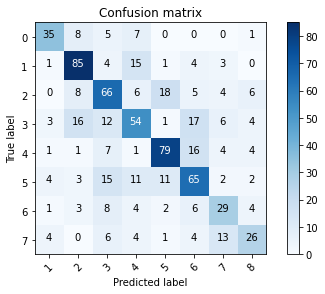

In [39]:
y_pred = rs.best_estimator_.predict(X_test_without_special_columns)
plot_confusion_matrix(y_test, y_pred)

In [40]:
man_actors   = [x for x in examples['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in examples['actor'].unique() if x % 2 != 0]

In [41]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'audio_type', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'audio_type', [1])

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'audio_type', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'audio_type', [1])

man_features, man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features, woman_y_true = filter_set(X_test, y_test, 'actor', woman_actors)

man_features = exclude_columns(man_features, special_columns)
woman_features = exclude_columns(woman_features, special_columns)

Audios Cantados vs Hablados:

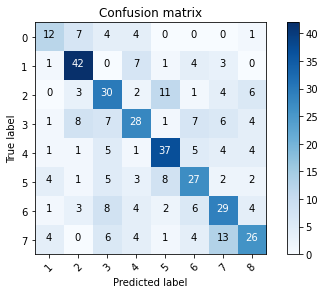

Hiper parameters: {'n_estimators': 17, 'learning_rate': 0.195}
Best score: 0.5255106318359839
Accuracy: 53.721 %


In [42]:
y_pred = rs.best_estimator_.predict(speechs_features)

plot_confusion_matrix(speechs_y_true, y_pred)
show_summary(rs, speechs_features, speechs_y_true)

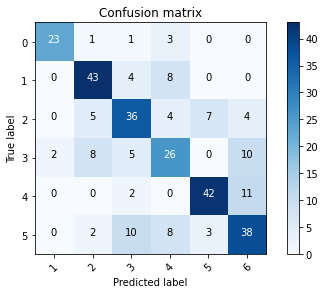

Hiper parameters: {'n_estimators': 17, 'learning_rate': 0.195}
Best score: 0.5255106318359839
Accuracy: 67.974 %


In [43]:
y_pred = rs.best_estimator_.predict(songs_features)

plot_confusion_matrix(songs_y_true, y_pred)
show_summary(rs, songs_features, songs_y_true)

Audios de  voces feneninas vs masculinas:

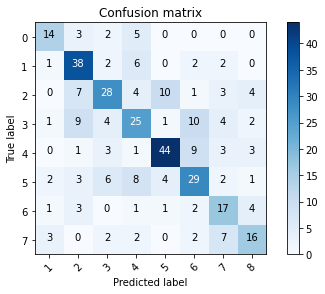

Hiper parameters: {'n_estimators': 17, 'learning_rate': 0.195}
Best score: 0.5255106318359839
Accuracy: 57.337 %


In [44]:
y_pred = rs.best_estimator_.predict(woman_features)

plot_confusion_matrix(woman_y_true, y_pred)
show_summary(rs, woman_features, woman_y_true)

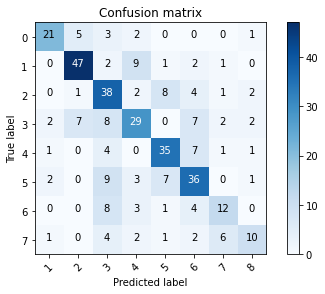

Hiper parameters: {'n_estimators': 17, 'learning_rate': 0.195}
Best score: 0.5255106318359839
Accuracy: 61.957 %


In [45]:
y_pred = rs.best_estimator_.predict(man_features)

plot_confusion_matrix(man_y_true, y_pred)
show_summary(rs, man_features, man_y_true)

#### 4. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:

A continuación definimos la funcion usada para extraer features del archivo de audio. Esta funcion agrega ruido al audio antes de extraer los features de manera que estos esten afectados por el ruido:

In [46]:
from librosa.feature import rms
import soundfile as sf
import uuid

def snr(audio, noise):
    return 20 * np.log10(np.quantile(rms(audio), 0.9) / np.quantile(rms(0.005 * noise), 0.9))

def append_noise(audio, level=1):
    noise = np.random.uniform(low=-level, high=level, size=(len(audio),))
    return snr(audio, noise) * noise + audio

def create_new_file_with_noise(path, level):
    audio, samplerate = sf.read(path)
    
    file_parts = path.split('/')
    file_parts[-1] = '{}-{}'.format(uuid.uuid1(), file_parts[-1])
    new_path = '/'.join(file_parts)
    
    sf.write(new_path, append_noise(audio, level), samplerate)
    return new_path

In [47]:
example_path = X_test['file_path'].values[0]
example_path

'./speech/Actor_07/03-01-03-02-01-02-07.wav'

In [48]:
play_audio(example_path)

In [49]:
noise_example_path = create_new_file_with_noise(example_path, level=0.0001)
noise_example_path

'./speech/Actor_07/8c74f63c-d0bd-11eb-83e8-2379067f1990-03-01-03-02-01-02-07.wav'

In [50]:
play_audio(noise_example_path)

In [51]:
def feature_extraction_with_noise(file_path, level):
    noise_file_path = create_new_file_with_noise(file_path, level)
    return get_functional_feats(noise_file_path)

In [52]:
feature_extraction_with_noise(noise_example_path, level=0.0001)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/8c7aa91a-d0bd-11eb-83e8-2379...,0 days,0 days 00:00:04.037354167,37.093266,0.07169,35.747932,37.18108,39.516861,3.768929,40.834423,...,0.01515,0.00112,0.167271,2.238806,2.015113,0.18125,0.078809,0.332857,0.435782,-30.533836


In [53]:
feature_extraction_with_noise(noise_example_path, level=0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/8c8bb746-d0bd-11eb-83e8-2379...,0 days,0 days 00:00:04.037354167,37.712639,0.047665,35.869736,37.559437,39.599972,3.730236,32.415745,...,0.014843,0.000724,0.416129,2.487562,2.015113,0.13875,0.071665,0.298889,0.406488,-28.119463


In [54]:
def generate_noise_set(example_paths, level):
    dataset = Dataset()
    examples = dataset.search_by_paths(
        paths = example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, level)
    )
    X, y = features_target(examples)
    return exclude_columns(X, special_columns), y

In [55]:
test_example_paths = X_test['file_path'].unique()

In [56]:
accuracy = []
levels = [0.0001, 0.0002, 0.0005, 0.0008]

for level in levels:
    X_noise, y_noise_true = generate_noise_set(test_example_paths, level=0.0001)
    y_noise_pred = rs.best_estimator_.predict(X_noise)
    acc = accuracy_score(y_noise_true, y_noise_pred)
    print('Level:', level, ', Acc:', acc)
    accuracy.append(acc)

  0%|          | 0/736 [00:00<?, ?it/s]

Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.75it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.25it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.91it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 77%|███████▋  | 570/736 [00:56<00:15, 10.77it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


100%|██████████| 736/736 [01:12<00:00, 10.12it/s]


ValueError: could not convert string to float: './speech/Actor_07/8c9f0d28-d0bd-11eb-83e8-2379067f1990-03-01-03-02-01-02-07.wav'

In [ ]:
plt.plot(level, accuracy)
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.show()